<a href="https://colab.research.google.com/github/jyj1206/SoloDeepLearning/blob/main/Chapter5_Handling_Visualization_of_'Many'_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 json, hashlib 튜토리얼

In [3]:
import json
a = {'value' : 5, 'value2': 10, 'seq' : [1, 2, 3, 4, 5]}

filename = 'test.json'
with open(filename, 'w') as f:
  json.dump(a, f)

with open(filename, 'r') as f:
  result = json.load(f)
  print(result)

{'value': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [4]:
!ls
!cat test.json

sample_data  test.json
{"value": 5, "value2": 10, "seq": [1, 2, 3, 4, 5]}

In [5]:
import hashlib
setting = {'value' : 5, 'value2': 10, 'seq' : [1, 2, 3, 4, 5], 'exp_name' : 'exp1'}

exp_name = setting['exp_name']
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
filename = f'{exp_name}-{hash_key}.json'
print(filename)

exp1-8ad3bc.json


## seaborn 튜토리얼

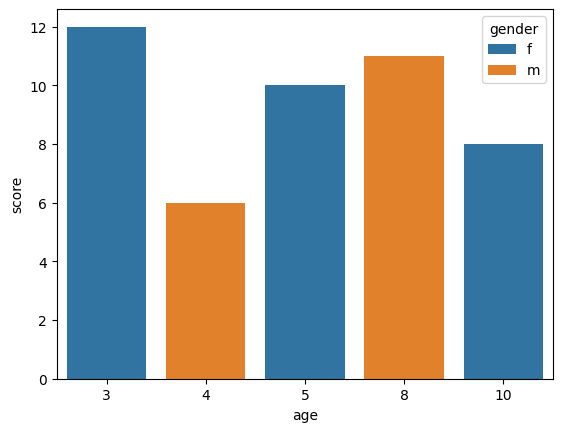

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


a = [
    {'age': 5, 'gender': 'f', 'score': 10, 't': 1},
    {'age': 4, 'gender': 'm', 'score': 6, 't': 2},
    {'age': 8, 'gender': 'm', 'score': 11, 't': 3},
    {'age': 10, 'gender': 'f', 'score': 8, 't': 3},
    {'age': 3, 'gender': 'f', 'score': 12, 't': 1}
]

df = pd.DataFrame(a)

sns.barplot(x='age', y='score', hue='gender', data=df)
plt.show()

# 실습

In [7]:
!mkdir results
!ls

results  sample_data  test.json


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy

## 데이터 전처리

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

100%|██████████| 170M/170M [00:02<00:00, 82.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 모델 설계

In [10]:
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act
    self.dropout = dropout
    self.use_bn = use_bn
    self.use_xavier = use_xavier

    self.fc_in = nn.Linear(self.in_dim, self.hid_dim)

    self.linears = nn.ModuleList()
    self.bns = nn.ModuleList()
    for i in range(self.n_layer - 1):
      self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
      if self.use_bn:
        self.bns.append(nn.BatchNorm1d(self.hid_dim))

    self.fc_out = nn.Linear(self.hid_dim, self.out_dim)

    if self.act == 'relu':
      self.act = nn.ReLU()
    elif act == 'tanh':
      self.act = nn.Tanh()
    elif act == 'sigmoid':
      self.act = nn.Sigmoid()
    else:
      raise ValueError('no valid activation function selected!')

    self.dropout = nn.Dropout(self.dropout)
    if self.use_xavier:
      self.xavier_init()

  def forward(self, x):
    x = self.fc_in(x)
    for i in range(len(self.linears)):
      x = self.act(self.linears[i](x))
      x = self.bns[i](x)
      x = self.dropout(x)
    x = self.fc_out(x)
    return x

  def xavier_init(self):
    for linear in self.linears:
      nn.init.xavier_normal_(linear.weight)
      linear.bias.data.fill_(0.01)

## 학습 함수

In [11]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)

        if args.device == 'cuda':
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

## 검증 함수

In [12]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)

            if args.device == 'cuda':
              images = images.cuda()
              labels = labels.cuda()

            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

## 테스트 함수

In [13]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)

            if args.device == 'cuda':
              images = images.cuda()
              labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

## experiment 함수

In [14]:
def experiment(partition, args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)

    if args.device == 'cuda':
      net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #

        print(f'Epoch {epoch}, Acc(train/val): {train_acc:2.2f}/{val_acc:2.2f}, Loss(train/val) {train_loss:2.2f}/{val_loss:2.2f}. Took {te-ts:2.2f} sec')

    test_acc = test(net, partition, args)

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

## experiment 저장 파일 다루기 위한 함수

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']
    del setting['device']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

## Experiment

In [16]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]

if torch.cuda.is_available():
    args.device = 'cuda'
else:
    args.device = 'cpu'

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=500, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, device='cuda', n_layer=1)
Epoch 0, Acc(train/val): 32.12/26.68, Loss(train/val) 3.67/2.26. Took 7.53 sec
Epoch 1, Acc(train/val): 37.41/35.46, Loss(train/val) 1.81/1.87. Took 6.75 sec
Epoch 2, Acc(train/val): 36.44/36.48, Loss(train/val) 1.93/1.82. Took 6.86 sec
Epoch 3, Acc(train/val): 39.01/33.47, Loss(train/val) 1.76/1.92. Took 7.12 sec
Epoch 4, Acc(train/val): 37.22/36.28, Loss(train/val) 2.16/1.84. Took 6.72 sec
Epoch 5, Acc(train/val): 40.51/33.38, Loss(train/val) 1.73/1.90. Took 6.49 sec
Epoch 6, Acc(train/val): 38.42/37.13, Loss(train/val) 2.03/1.85. Took 7.08 sec
Epoch 7, Acc(train/val): 40.63/35.90, Loss(train/val) 1.72/1.90. Took 6.63 sec
Epoch 8, Acc(train/val): 38.80/37.51, Loss(train/val) 2.15/1.83. Took 6.84 sec
Epoch 9, Acc(train/val): 41.64/38.7

In [17]:
!ls results
!cat result/exp1_n_layer_hid_dim-41b634.json

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json
cat: result/exp1_n_layer_hid_dim-41b634.json: No such file or directory


In [18]:
load_exp_result('exp1')

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[3.66788136503499, 1.8110812811335182, 1.93131...","[2.262009358406067, 1.872164797782898, 1.82193...","[32.1175, 37.4075, 36.435, 39.005, 37.215, 40....","[26.68, 35.46, 36.48, 33.47, 36.28, 33.38, 37....",41.6375,38.79,38.00,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
1,"[1.8061528312172859, 1.5616865051779778, 1.472...","[1.7316208600997924, 1.6110695242881774, 1.593...","[35.395, 44.1575, 47.46, 49.625, 51.37, 53.185...","[37.48, 42.72, 42.85, 47.12, 46.29, 49.42, 48....",57.4550,50.92,51.41,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
2,"[1.8672532215239896, 1.5740647984158462, 1.477...","[1.7228776454925536, 1.7287152409553528, 1.556...","[34.6775, 43.62, 47.055, 49.5175, 51.8475, 53....","[38.88, 38.6, 44.21, 43.02, 46.97, 46.43, 46.9...",59.3925,49.94,50.42,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
3,"[3.0057423851292606, 1.8037186997711279, 1.783...","[1.950140118598938, 1.9021605849266052, 1.9503...","[32.5475, 37.61, 38.38, 37.505, 39.5775, 39.24...","[32.25, 33.37, 32.09, 34.44, 35.38, 35.31, 33....",40.5000,38.32,37.68,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
4,"[1.8863066267815365, 1.6172720740555198, 1.516...","[1.8469253420829772, 1.7242668271064758, 1.663...","[34.4475, 42.9375, 46.4925, 48.6175, 50.5225, ...","[36.42, 38.58, 42.37, 44.91, 43.24, 44.4, 49.1...",56.3550,50.74,49.98,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
5,"[1.8088572207529834, 1.586675729721215, 1.5028...","[1.7525835752487182, 1.6496778964996337, 1.555...","[36.2725, 43.785, 46.9525, 49.3375, 50.9475, 5...","[38.86, 41.12, 44.99, 46.89, 49.87, 45.81, 49....",55.9850,49.25,49.07,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2


## 결과 시각화

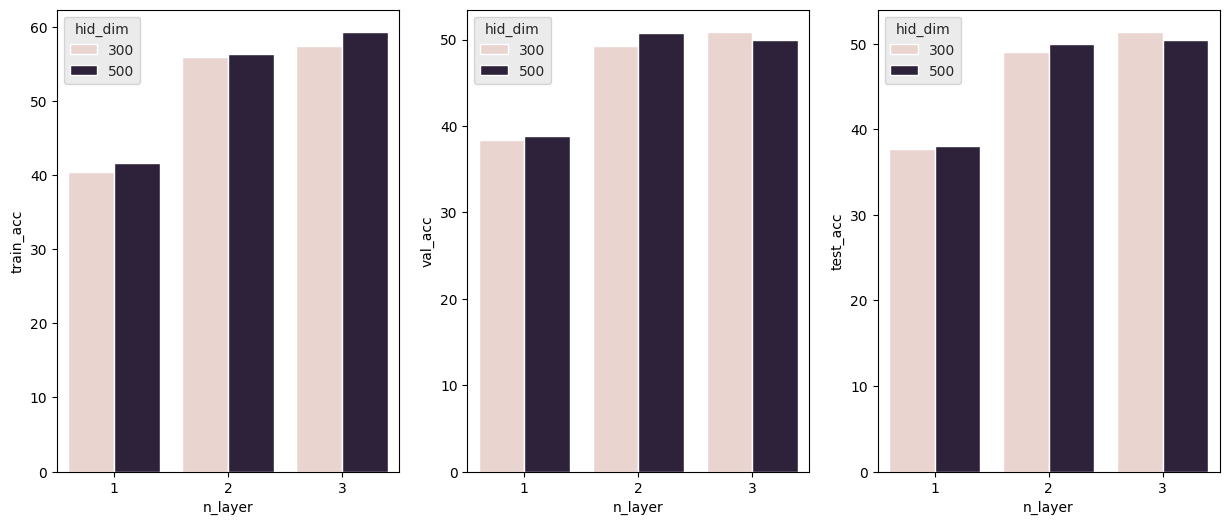

In [19]:
result = load_exp_result('exp1')

# epoch이 끝났을때 최종 acc 값 비교하기 (train/validate/test)
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {'axes.facecolor' : ".9"})

sns.barplot(x = 'n_layer', y ='train_acc', hue='hid_dim', data=result, ax=ax[0])
sns.barplot(x = 'n_layer', y ='val_acc', hue='hid_dim', data=result, ax=ax[1])
sns.barplot(x = 'n_layer', y ='test_acc', hue='hid_dim', data=result, ax = ax[2])
plt.show()

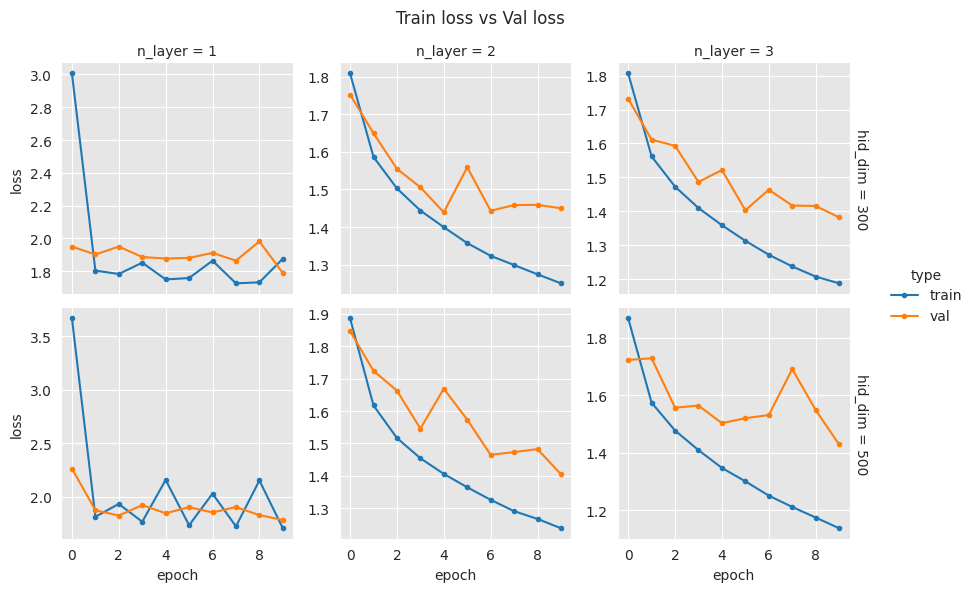

In [20]:
# 각 실험에서 epoch에 따른 loss의 변화 확인
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')

# 실험한 종류
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()

list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]

        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)



# row를 'hid_dim' 변수로 나누고, col을 'n_layer' 변수로 나누어서 grid를 생성
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)

# 각 grid에 x축은 'epoch', y축은 'loss'로 선 그래프를 그림. marker='.'로 각 점을 표시
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)
plt.show()

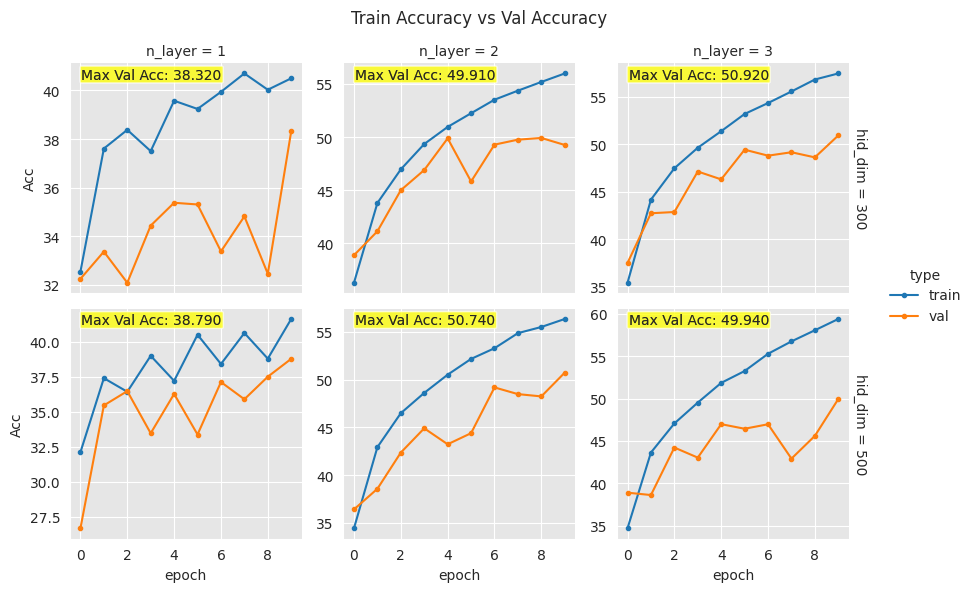

In [22]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1] == value1]
        row = row.loc[df[var2] == value2]

        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        max_val_acc = max(val_accs)  # 최대 val accuracy 계산

        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type': 'train', 'Acc': train_acc, 'max_val_acc': max_val_acc, 'epoch': epoch, var1: value1, var2: value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type': 'val', 'Acc': val_acc, 'max_val_acc': max_val_acc, 'epoch': epoch, var1: value1, var2: value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Max Val Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

g = g.map(show_acc, 'epoch', 'Acc', 'max_val_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')

plt.subplots_adjust(top=0.89)

plt.show()
